# Plot abrupt CO2 anomalies and fit different linear responses

In [50]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import random as rd
from lmfit import Model
from lmfit.model import save_modelresult, load_modelresult
from scipy import optimize
plt.rcParams.update({'figure.max_open_warning': 0})
import importlib
from estimation import *
import xarray as xr


## Define linear temperature models

In [33]:
def exp_part1(t, S1, tau1):
    return S1*(1 - np.exp(-t/tau1))
def exp_part2(t, S2, tau2):
    return S2*(1 - np.exp(-t/tau2))
def exp_part3(t, S3, tau3):
    return S3*(1 - np.exp(-t/tau3))
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

def twoexp_function(t, S1, S2, tau1, tau2):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2)
def threeexp_function(t, S1, S2, S3, tau1, tau2, tau3):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + exp_part3(t, S3, tau3)
def expandosc_function(t, S1, S2, Sosc1, Sosc2, tau1, tau2, taup, Tq):
    return exp_part1(t, S1, tau1) + exp_part2(t, S2, tau2) + osc_parts(t, Sosc1, Sosc2, taup, Tq)

exp_model1 = Model(exp_part1); exp_model2 = Model(exp_part2); 
twoexp_model = Model(twoexp_function);
twoexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
twoexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
twoexp_model.set_param_hint('tau1', value=4, min=0, max=8)
twoexp_model.set_param_hint('tau2', value=20, min=8, max=1000)

exp_model3 = Model(exp_part3); threeexp_model = Model(threeexp_function);
threeexp_model.set_param_hint('S1', value=4, min=0, max=10.0)
threeexp_model.set_param_hint('S2', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('S3', value=2, min=0, max=10.0)
threeexp_model.set_param_hint('tau1', value=4, min=0, max=8)
threeexp_model.set_param_hint('tau2', value=20, min=8, max=100)
threeexp_model.set_param_hint('tau3', value=200, min=100, max=1000)

osc_model = Model(osc_parts); expandosc_model = Model(expandosc_function)
expandosc_model.set_param_hint('S1', value=4, min=0, max=10.0)# guess the same as for two-box model 
expandosc_model.set_param_hint('S2', value=2, min=0, max=10.0)
expandosc_model.set_param_hint('Sosc1', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('Sosc2', value=0.5, min=0, max=4.0)
expandosc_model.set_param_hint('tau1', value=4, min=0, max=8)
expandosc_model.set_param_hint('tau2', value=20, min=8, max=1000)
expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
expandosc_model.set_param_hint('Tq', value=400, min=40, max=2000)

In [34]:
def modelresult_figure(response_model, model_result, years0, deltaT0, axis = None):
    # takes in response models: 'twoexp', 'threeexp', 'expandosc'
    if axis == None:
        #then create new axis:
        fig, axis = plt.subplots(figsize = [8,6])
        
    axis.set_xlabel('Year',fontsize = 18)
    axis.set_ylabel('T [K]',fontsize = 18)
    axis.set_xlim(min(years0),max(years0))
    axis.tick_params(axis='both',labelsize=18)
    axis.plot(years0, deltaT0, color = 'black')
    
    residuals = model_result.best_fit - model_result.data
    model_rmse = np.sqrt(np.mean(residuals**2))
    #model_rmse = np.sqrt(np.mean(model_result.residual**2))
    axis.plot(years0, model_result.best_fit, '-', label='best fit', color = 'blue', linewidth = 2)
    
    # plot components
    axis.plot(years0, exp_model1.eval(model_result.params, t=years0), color = 'lightblue')
    
    if response_model == 'twoexp':
        axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Two-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'tau1', 'tau2']
        textlabels = ['$S_1$', '$S_2$', r'$\tau_1$', r'$\tau_2$']
    elif response_model == 'threeexp':
        axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
        axis.plot(years0, exp_model3.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Three-exponential fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'S3', 'tau1', 'tau2', 'tau3']
        textlabels = ['$S_1$', '$S_2$', '$S_3$', r'$\tau_1$', r'$\tau_2$', r'$\tau_3$']
    elif response_model == 'expandosc':
        axis.plot(years0, exp_model2.eval(model_result.params, t=years0), color = 'lightblue')
        axis.plot(years0, osc_model.eval(model_result.params, t=years0), color = 'lightblue')
        axis.set_title('Two-exponential and oscillatory fit', fontsize = 18)
        partoshow = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
        textlabels = ['$S_1$', '$S_2$', '$S_{osc1}$', '$S_{osc2}$', r'$\tau_1$', r'$\tau_2$', r'$\tau_p$', r'$T_q$']
        
    estimates = [model_result.best_values[par] for par in partoshow]
    axis.text(0.01, 0.95, 'RMSE = ' + str(np.round(model_rmse,3)), transform=axis.transAxes, fontsize = 16)
    axis.text(0.75,0.55, 'Estimates:', fontsize=14, transform=axis.transAxes)
    for (ind, estimate) in enumerate(estimates):
        axis.text(0.75,0.5*(1-ind/8),textlabels[ind] + ' = ' + str('{:.2f}'.format(np.round(estimate,2))), fontsize=14, transform=axis.transAxes)
    return axis
    

In [58]:
def plot_3fits(years0, deltaT0, model, exp, load_results = False, save_results = False, save_figure = False):
    fig, ax = plt.subplots(ncols = 3, figsize = [25,6]);
    fig.suptitle(model + ' responses to ' + exp, fontsize = 22)
    response_models = ['twoexp', 'threeexp', 'expandosc']
    response_functions = [twoexp_function, threeexp_function, expandosc_function]
    
    rmse_values = []
    for (ax_index, axis) in enumerate(ax):
        response_model = response_models[ax_index]; response_function = response_functions[ax_index]
        
        result_file = '../model_results_longrunmip/' + model + '_' + exp + '_' + response_model + '_results.sav'
        if load_results == True:
            model_result = load_modelresult(result_file, funcdefs = {response_model + '_function': response_function})
            #model_rmse = np.sqrt(np.mean(model_result.residual**2))
            # attribute residual seems to be missing
            # but we can compute it manually from other attributes:
            residuals = model_result.best_fit - model_result.data
            model_rmse = np.sqrt(np.mean(residuals**2))
        else: # obtain new results
            if response_model == 'twoexp':
                model_to_fit = twoexp_model
            elif response_model == 'threeexp':
                model_to_fit = threeexp_model
            elif response_model == 'expandosc':
                model_to_fit = expandosc_model
                 
            model_result = model_to_fit.fit(deltaT0, t=years0)
            model_rmse = np.sqrt(np.mean(model_result.residual**2))
            if response_model == 'expandosc':
                twoexp_rmse = rmse_values[0]
                if model_rmse > twoexp_rmse: 
                    i=0;
                    while model_rmse > twoexp_rmse: # if worse than twoexp, then make new fit
                        print(i, model, exp)
                        taup_guess = 10**rd.uniform(np.log10(20), np.log10(1000))
                        Tq_guess = 10**rd.uniform(np.log10(40), np.log10(2000))
                        expandosc_model.set_param_hint('taup', value=taup_guess, min=20, max=1000)
                        expandosc_model.set_param_hint('Tq', value=Tq_guess, min=40, max=2000)
                        model_result = expandosc_model.fit(deltaT0, t=years0)
                        model_rmse = np.sqrt(np.mean(model_result.residual**2))
                        i += 1; 
                    # reset par hints:
                    expandosc_model.set_param_hint('taup', value=600, min=20, max=1000)
                    expandosc_model.set_param_hint('Tq', value=400, min=40, max=2000)
        if save_results == True:
             save_modelresult(model_result, result_file) 
        
        modelresult_figure(response_model, model_result, years0, deltaT0, axis = axis)
        rmse_values.append(model_rmse)
    if save_figure == True:
        plt.savefig('../Figures/LongRunMIP_modelcomparisons/' + model + '_' + exp + '_linresponses_comparison.pdf', format='pdf', dpi=600, bbox_inches="tight")
    return rmse_values
        

## Select dataset(s):

In [31]:
def find_longrunmip_files(model, exp):
    directory = '../longrunmip_data/'
    file_str = model + '_' + exp
    filenames = [f.name for f in os.scandir(directory) if file_str in f.name]
    filenames.sort()
    tas_file = filenames[1]; nettoa_file = filenames[0]
    return [tas_file, nettoa_file]

def get_tas(model, exp, add_0 = True, remove_nan = False, return_years = False):
    directory = '../longrunmip_data/'
    [tas_file, nettoa_file] = find_longrunmip_files(model, exp)
    ds_tas = xr.open_dataset(directory + tas_file)
    deltaT = ds_tas.tas.values
    if remove_nan == True:
        deltaT = deltaT[np.isnan(deltaT)==False]
    years = np.arange(1,len(deltaT)+1)
    if add_0 == True:
        deltaT = np.concatenate([[0],deltaT])
        years = np.concatenate(([0],years))
        
    if return_years == True:
        return [years, deltaT]
    else:
        return deltaT

def get_nettoa(model, exp, remove_nan = False, return_years = False):
    directory = '../longrunmip_data/'
    [tas_file, nettoa_file] = find_longrunmip_files(model, exp)
    ds_nettoa = xr.open_dataset(directory + nettoa_file)
    nettoa = ds_nettoa.netTOA.values
    if remove_nan == True:
        nettoa = nettoa[np.isnan(nettoa)==False]
    years = np.arange(1,len(nettoa)+1)
    if return_years == True:
        return [years, nettoa]
    else:
        return nettoa

In [20]:
all_abruptexp = {'MPIESM12': ['abrupt2x', 'abrupt4x', 'abrupt8x', 'abrupt16x'],
               'HadCM3L': ['abrupt2x', 'abrupt4x', 'abrupt6x', 'abrupt8x'],
               'FAMOUS': ['abrupt2x', 'abrupt4x'],
               'CNRMCM61': ['abrupt2x', 'abrupt4x'], #but this may be a duplicate of the CMIP6 runs?
               'CESM104': ['abrupt2x', 'abrupt4x', 'abrupt8x'],
               'CCSM3': ['abrupt2x', 'abrupt4x', 'abrupt8x'],
               'IPSLCM5A': ['abrupt4x'],
               'HadGEM2': ['abrupt4x'],
               'GISSE2R': ['abrupt4x'],
               'ECHAM5MPIOM': ['abrupt4x']
              }

[0.1526133918603012, 0.1453573875043357, 0.13445759450383601]


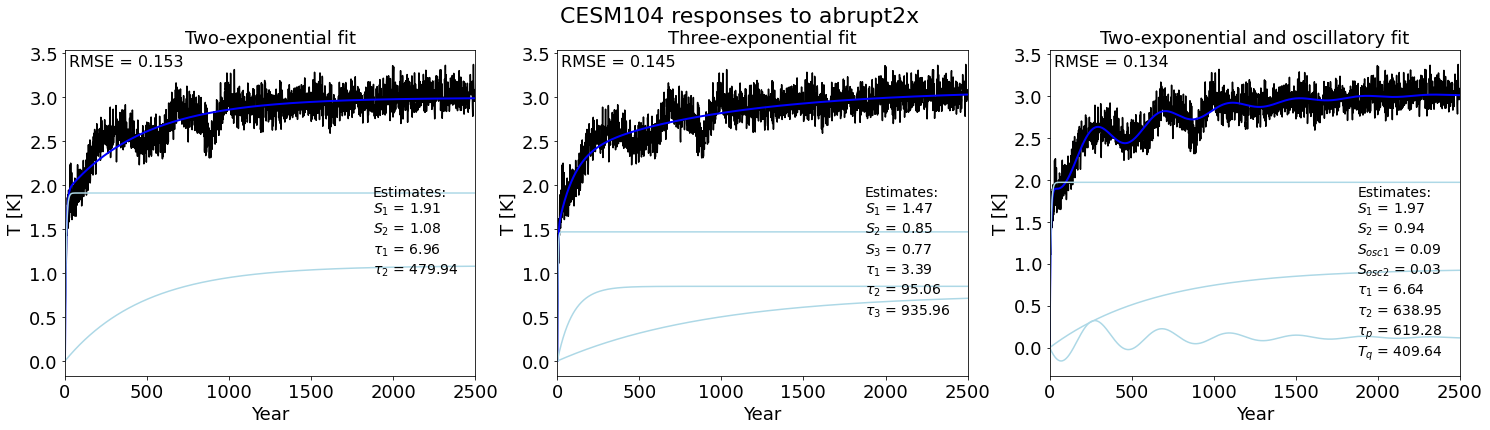

In [35]:
model = 'CESM104'
exp = 'abrupt2x'

[years0, deltaT0] = get_tas(model, exp, add_0 = True, remove_nan = True, return_years = True)
rms_values = plot_3fits(years0, deltaT0, model, exp)
print(rms_values)


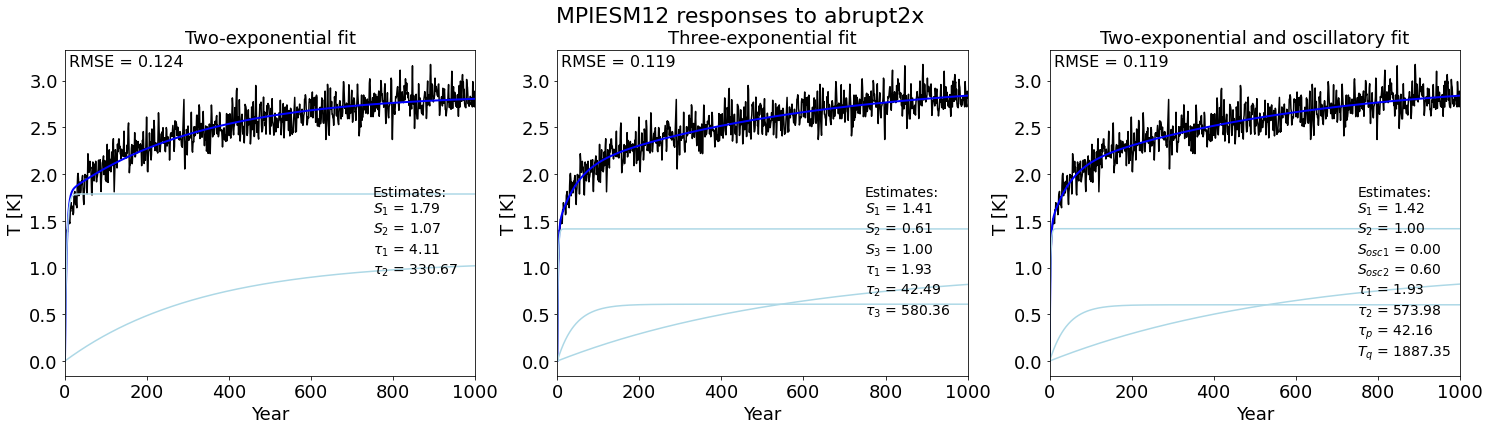

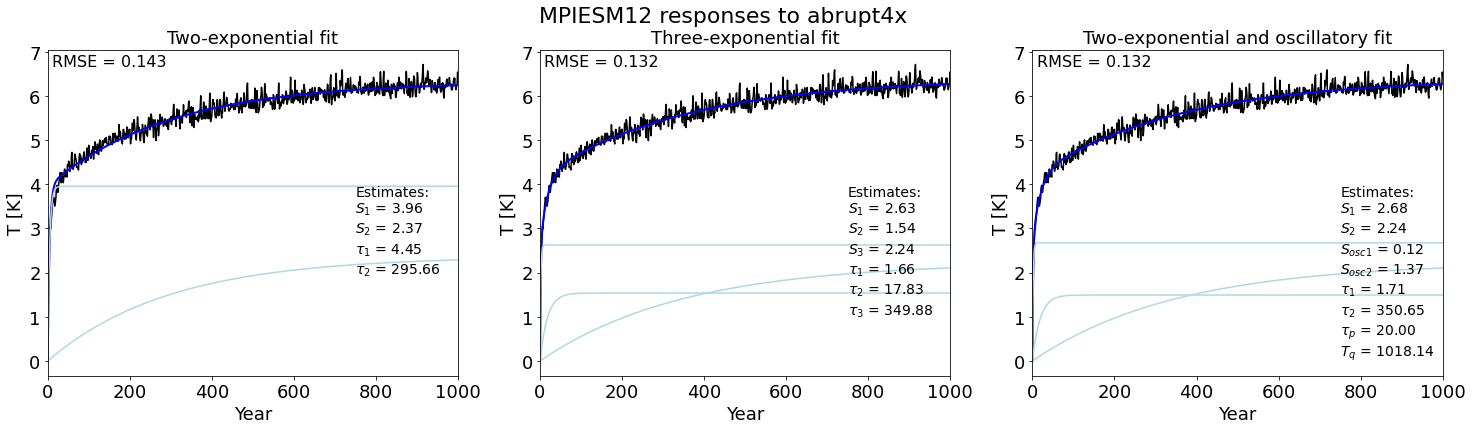

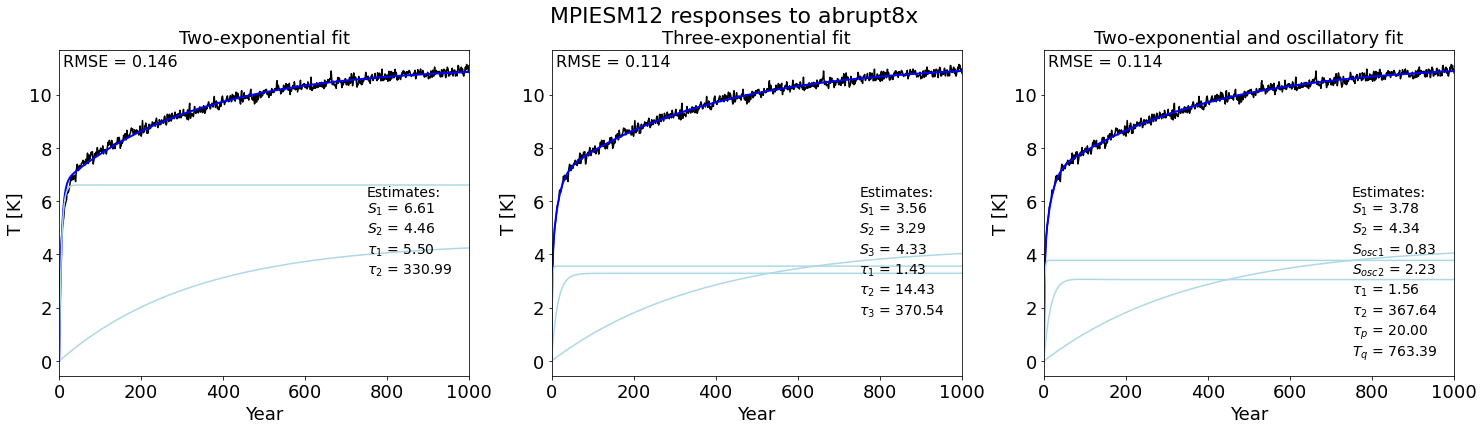

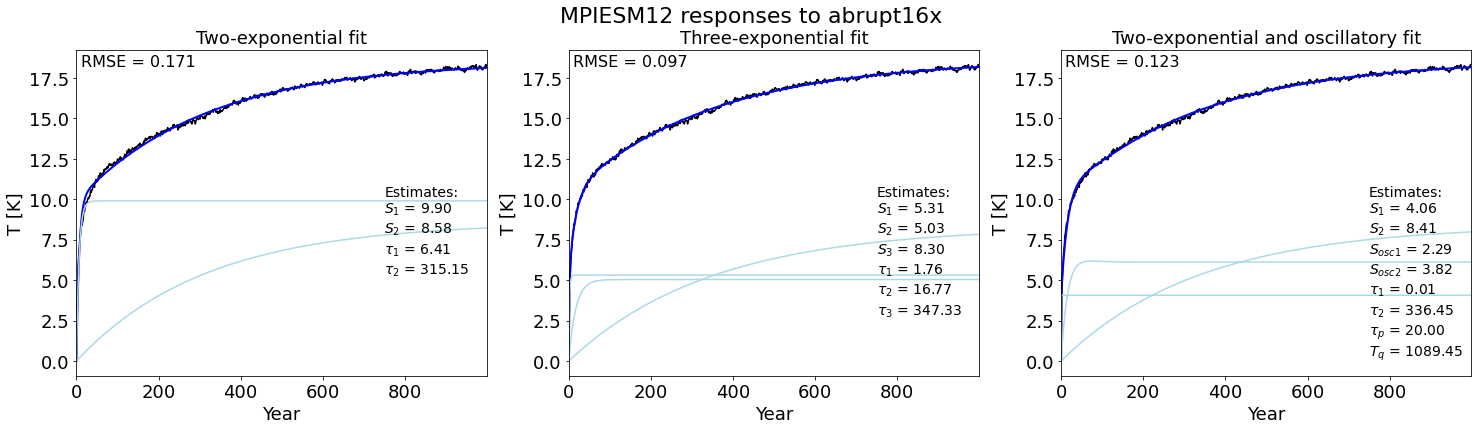

In [56]:
#model = 'HadCM3L'
model = 'MPIESM12'
for exp in all_abruptexp[model]:
    [years0, deltaT0] = get_tas(model, exp, add_0 = True, remove_nan = True, return_years = True)
    rmse_values = plot_3fits(years0, deltaT0, model, exp)


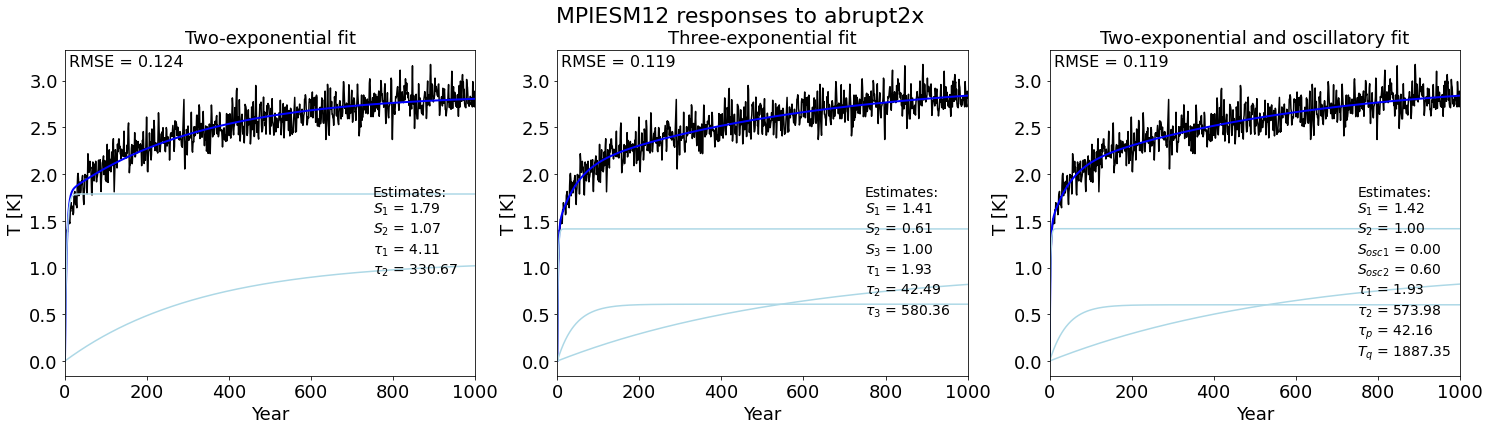

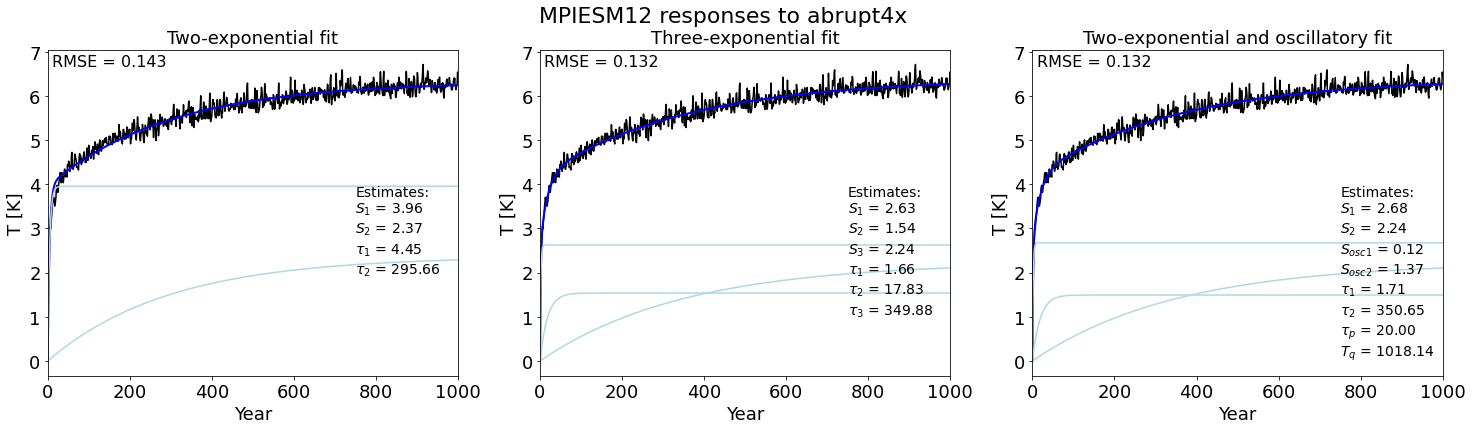

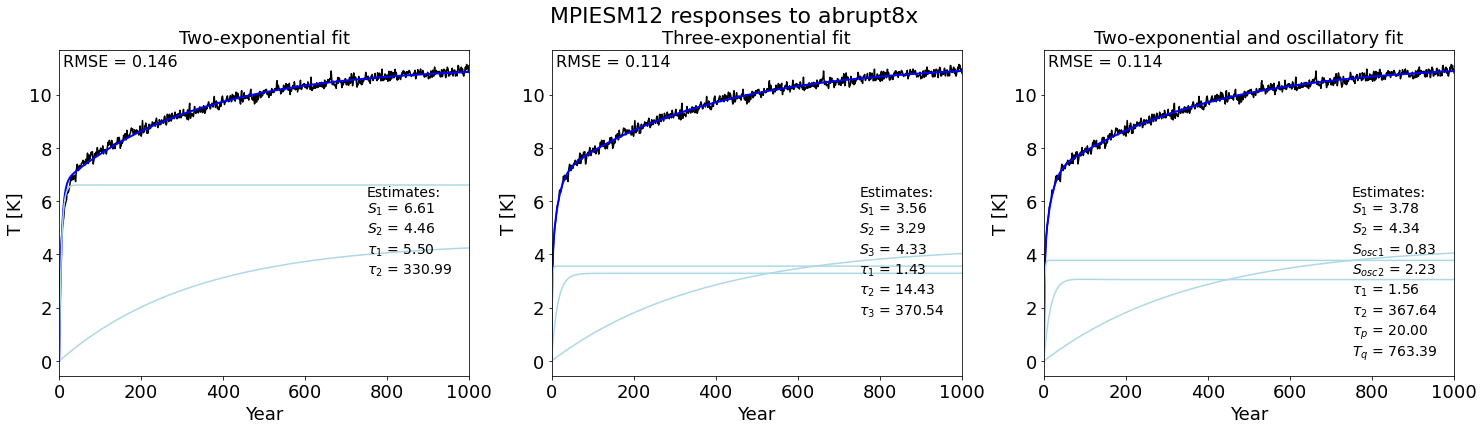

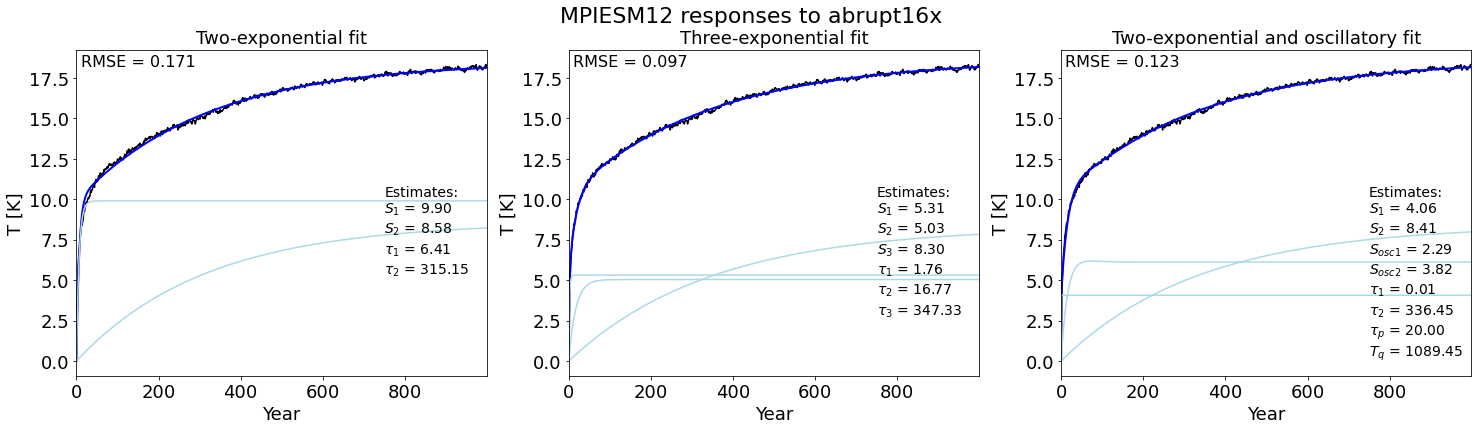

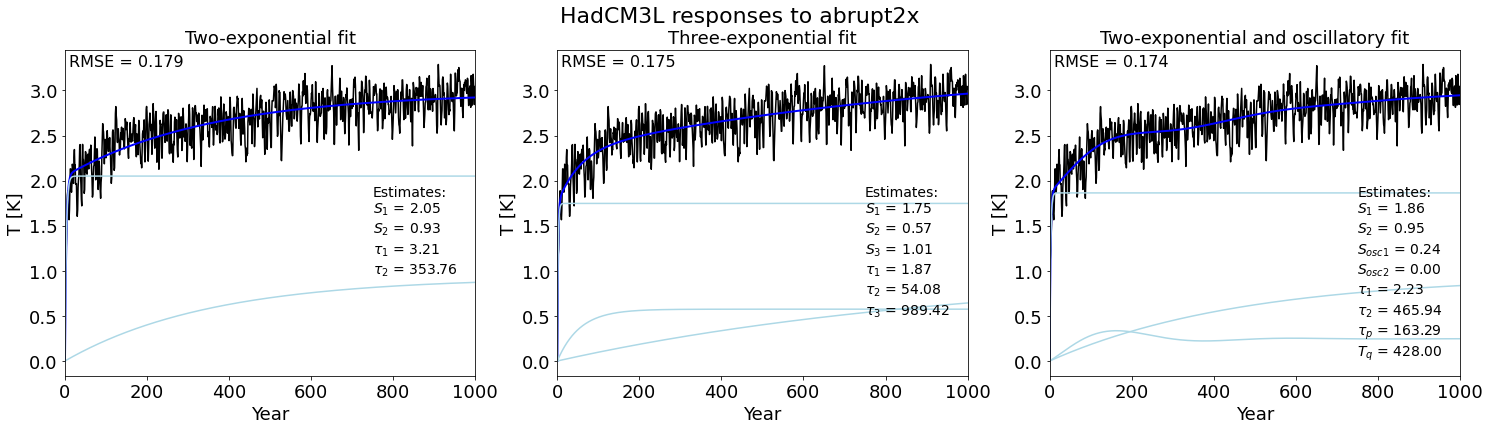

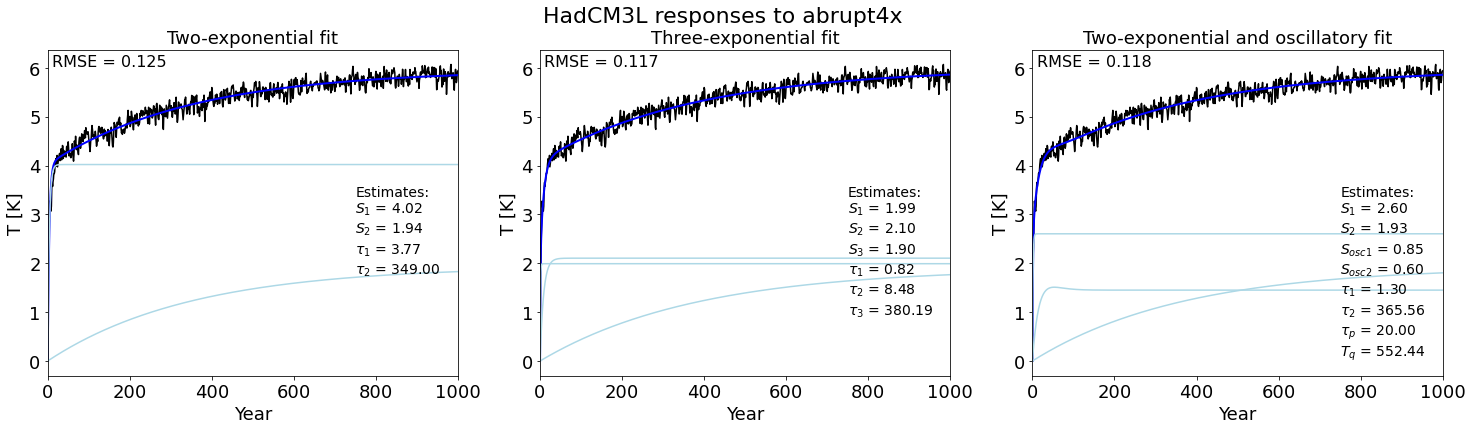

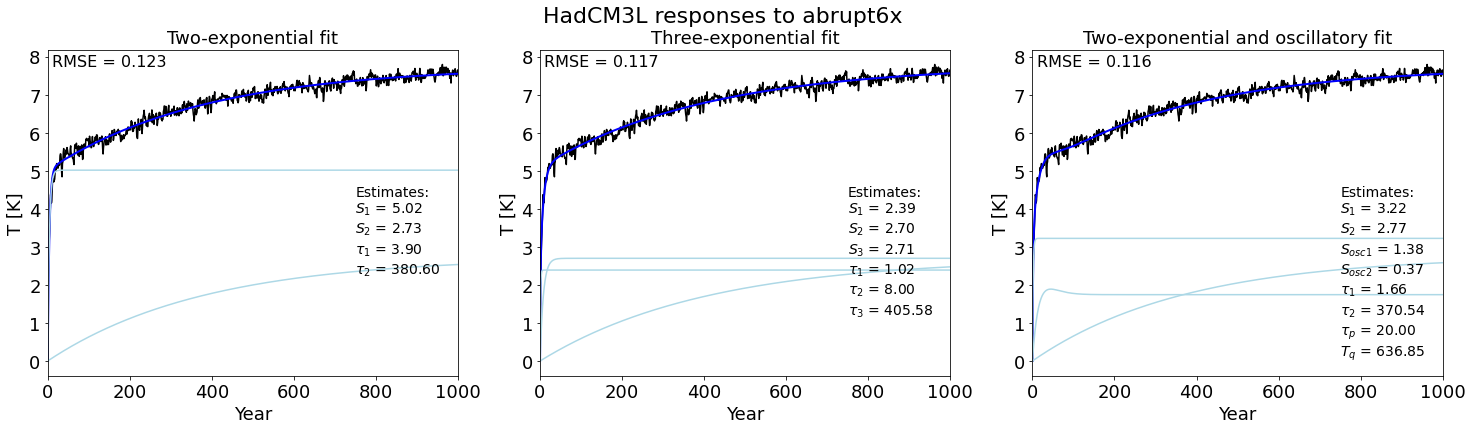

0 HadCM3L abrupt8x


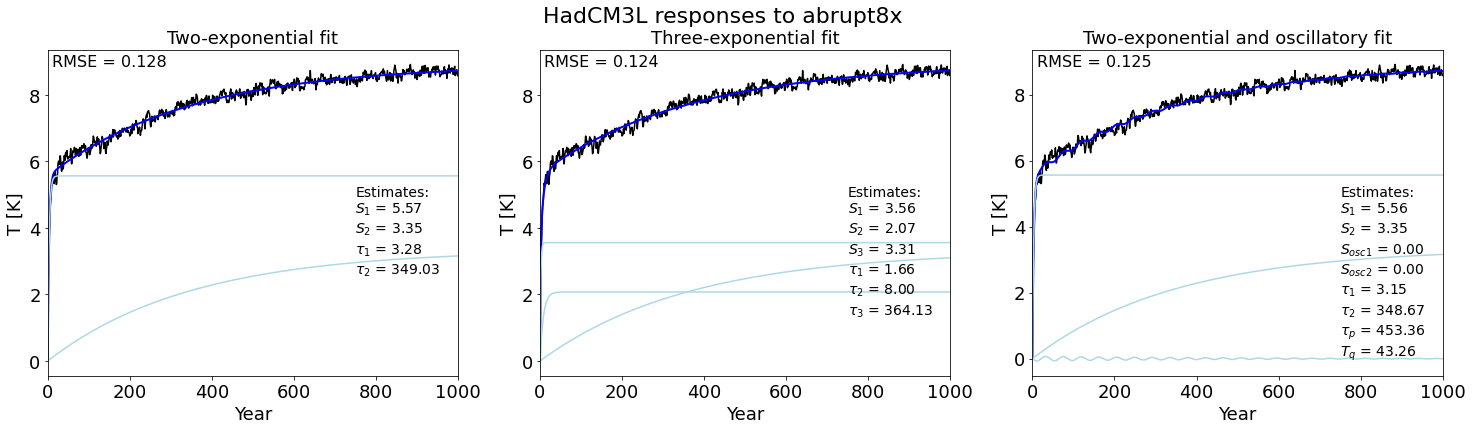

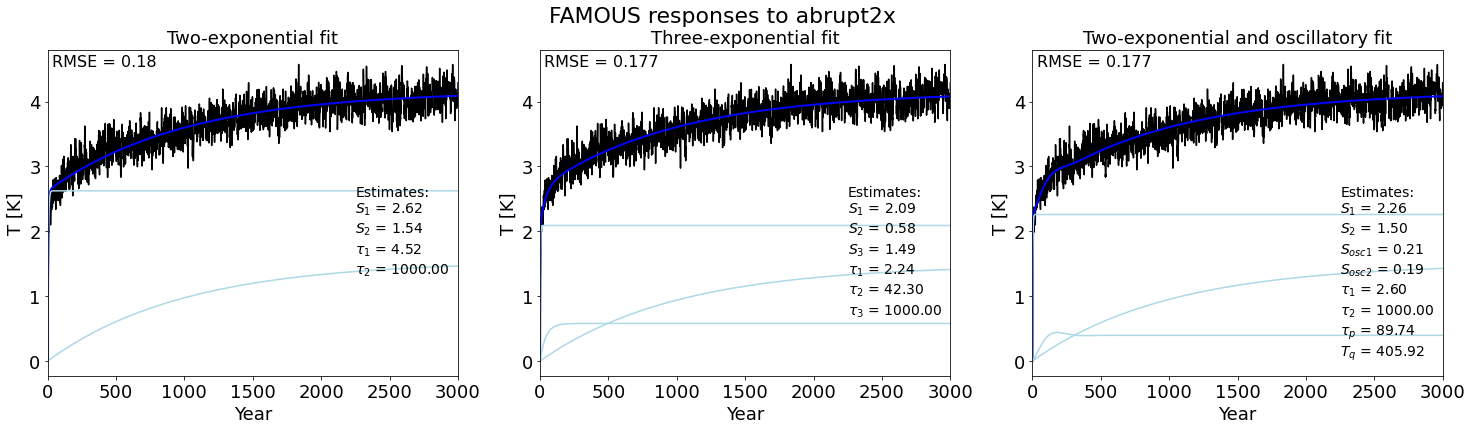

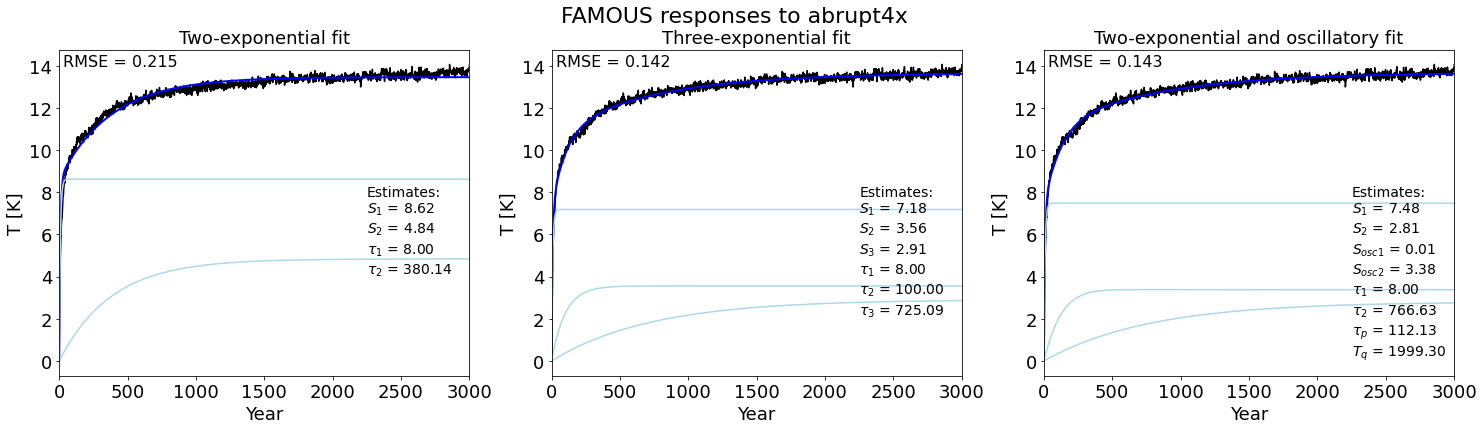

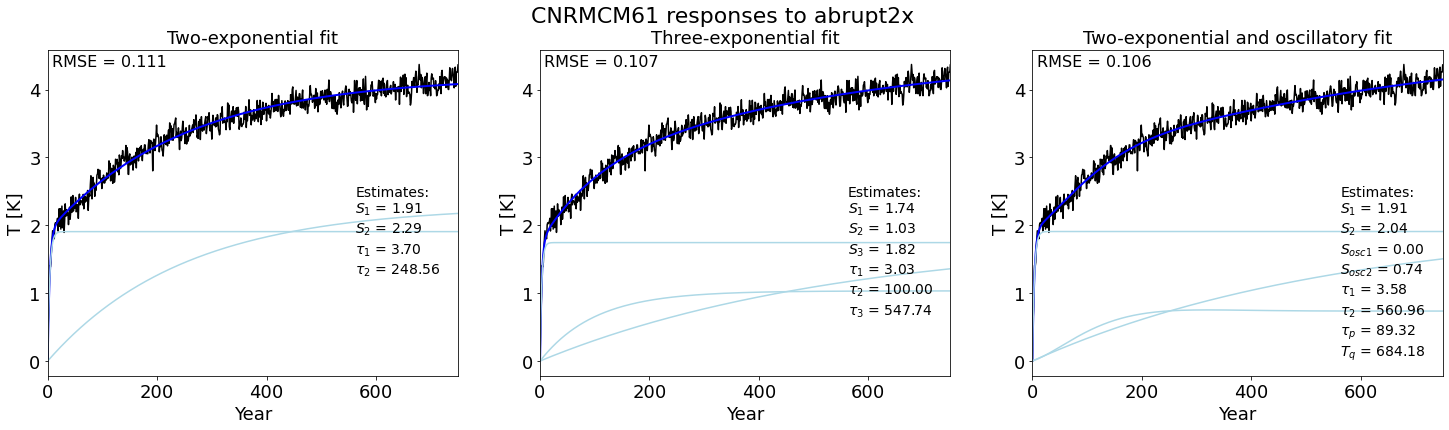

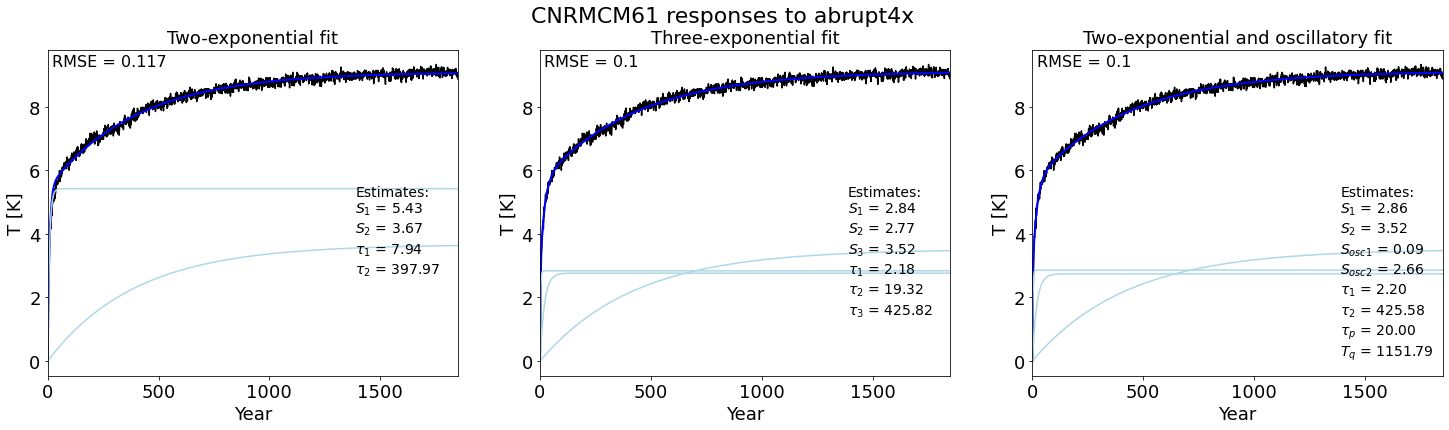

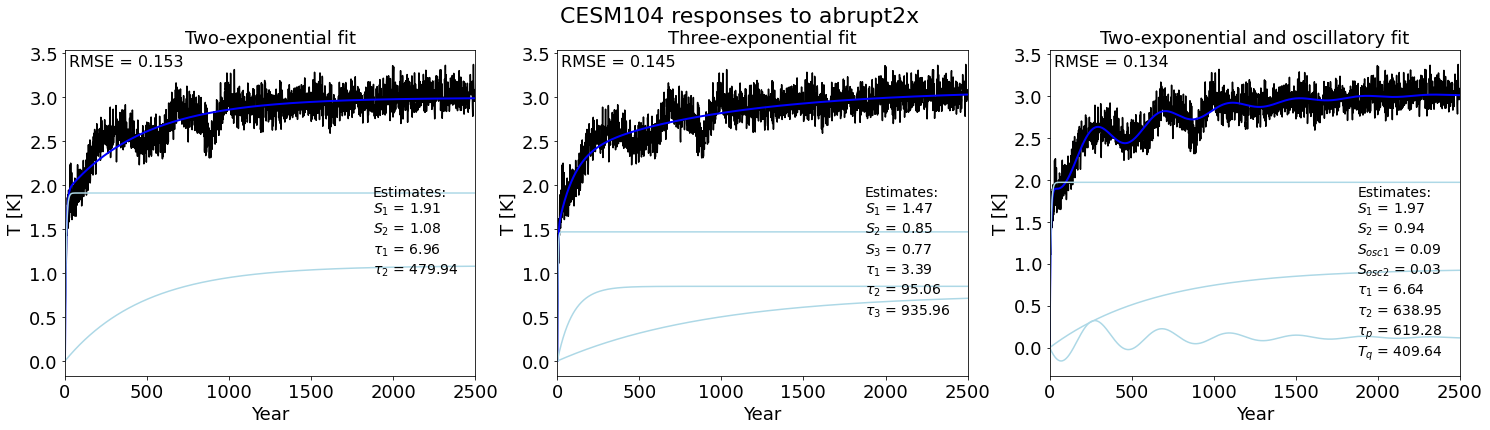

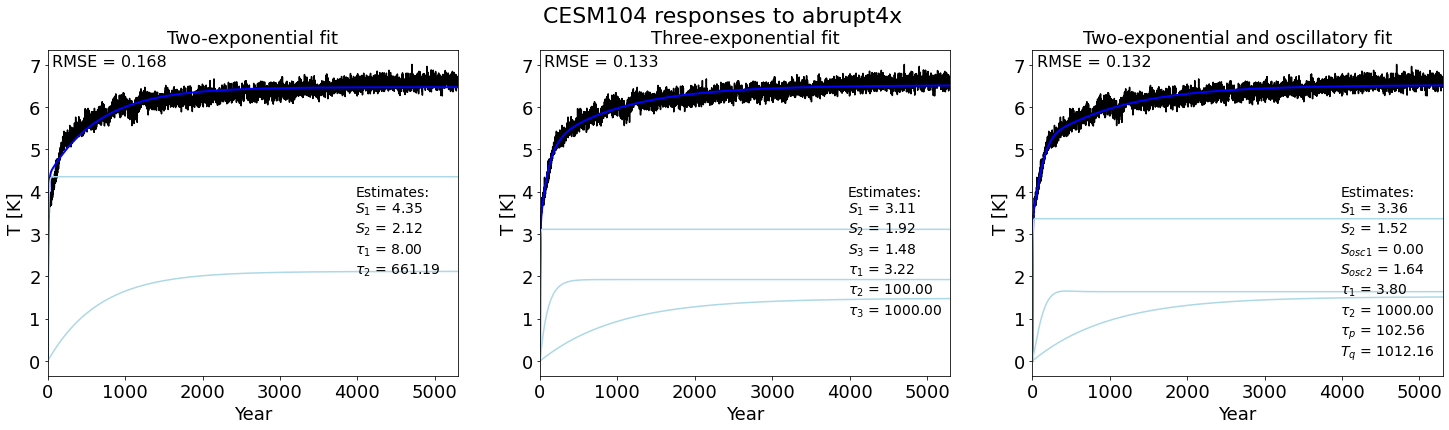

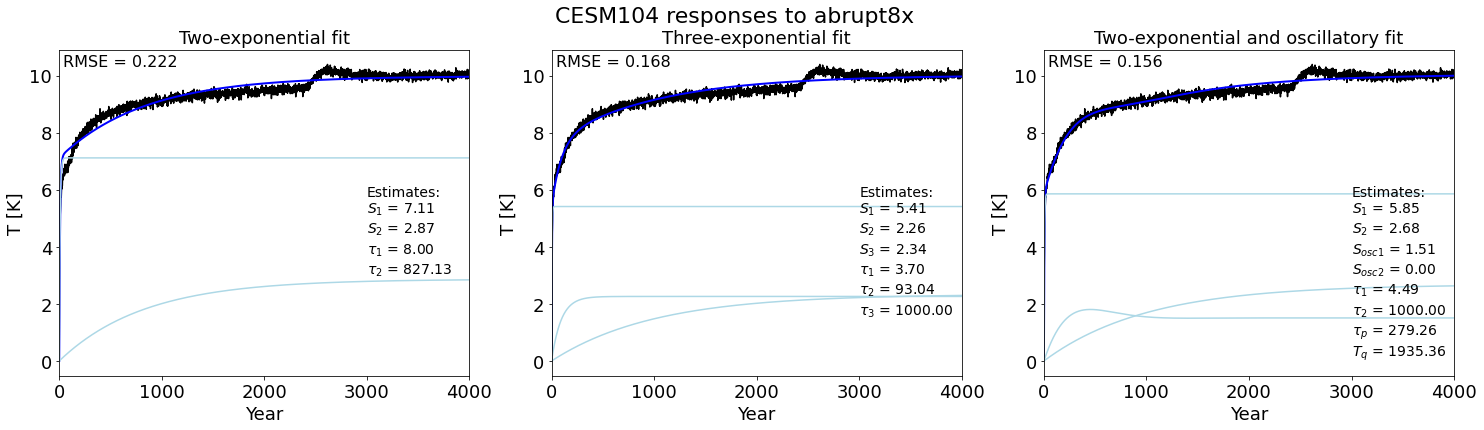

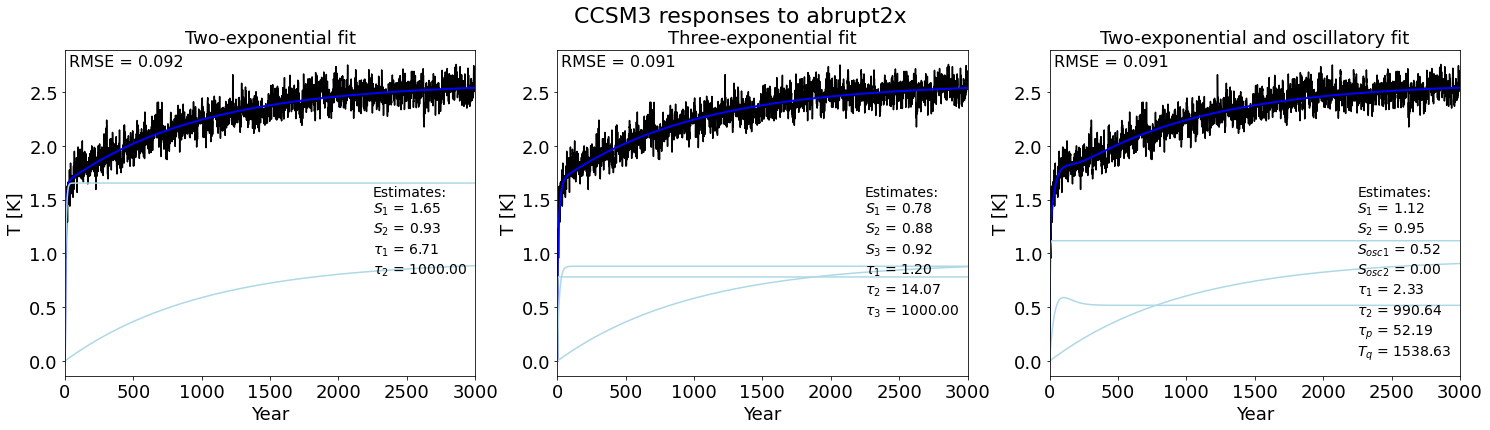

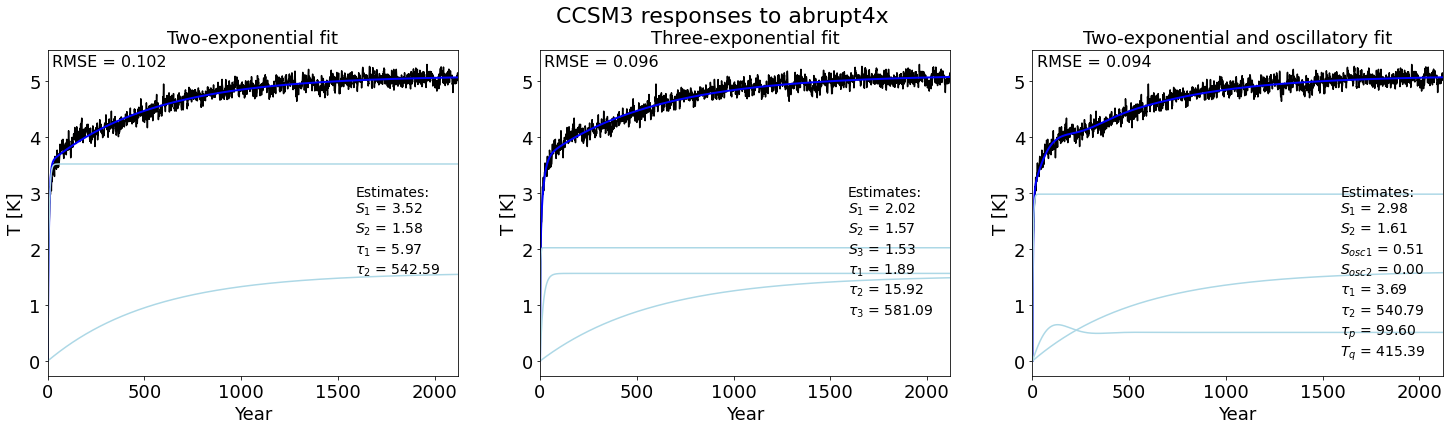

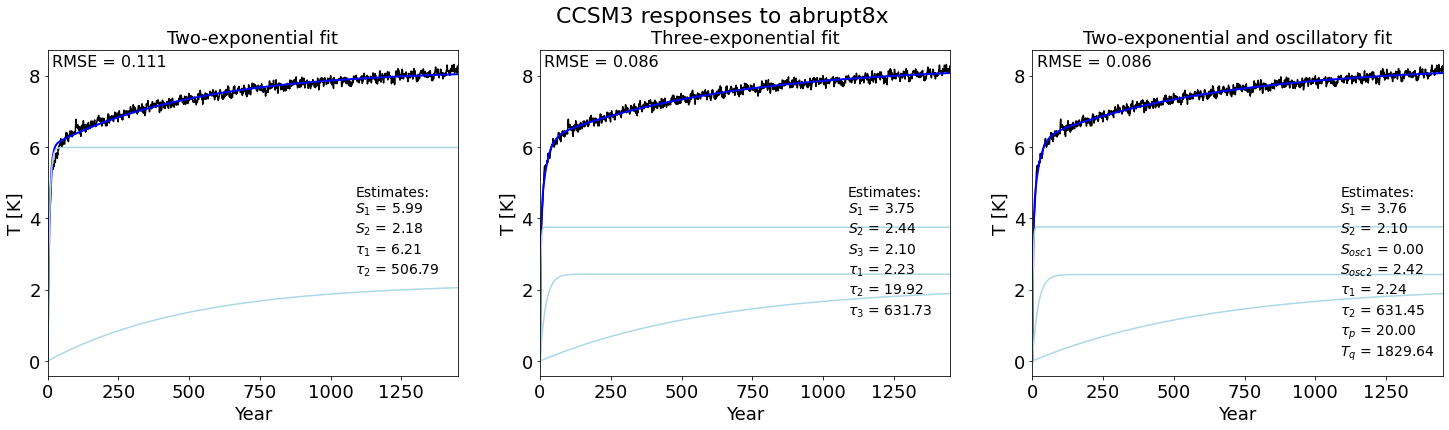

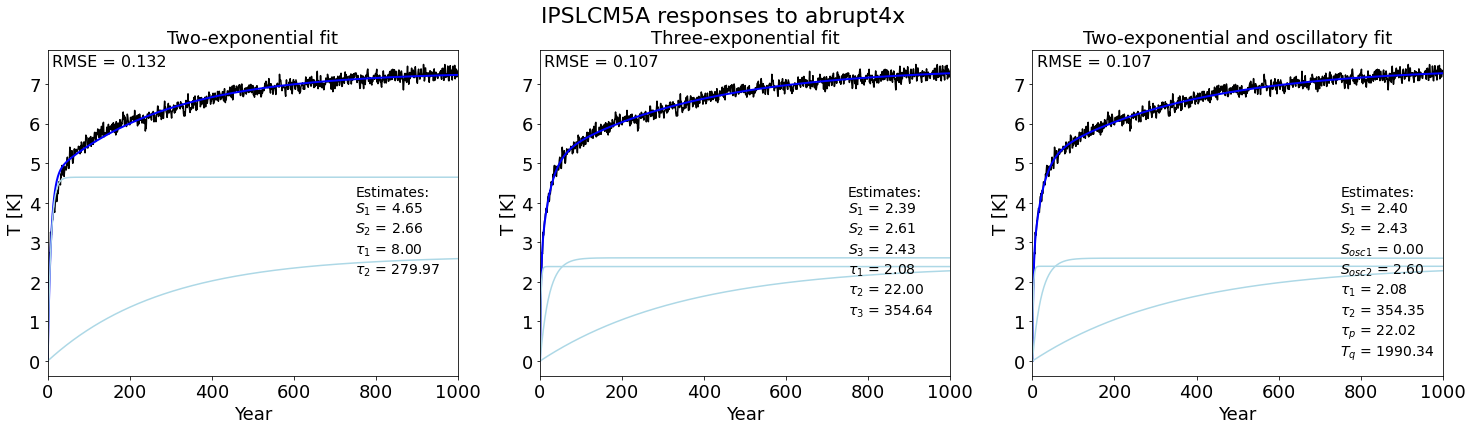

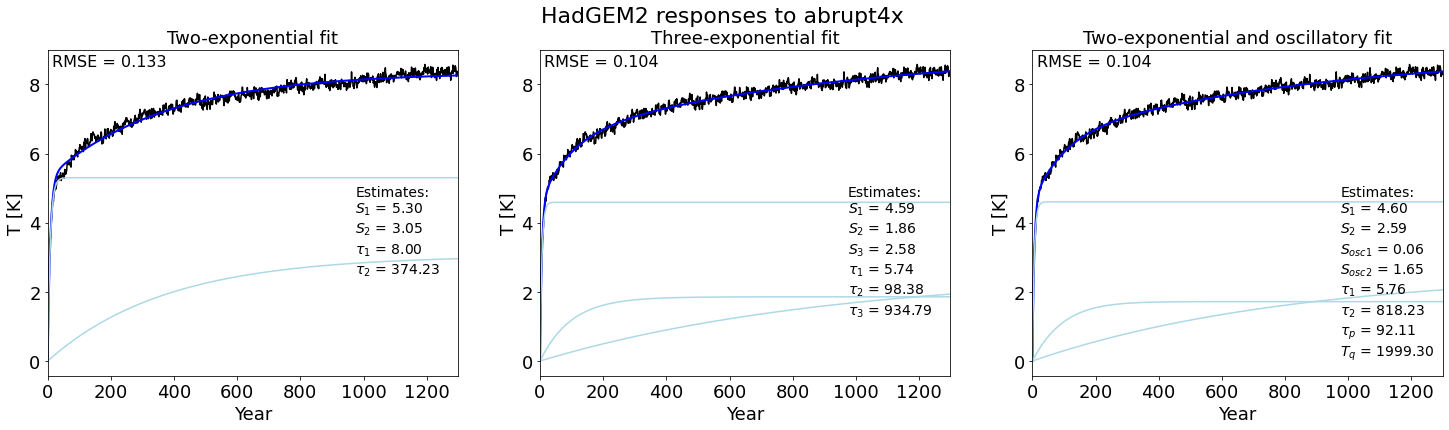

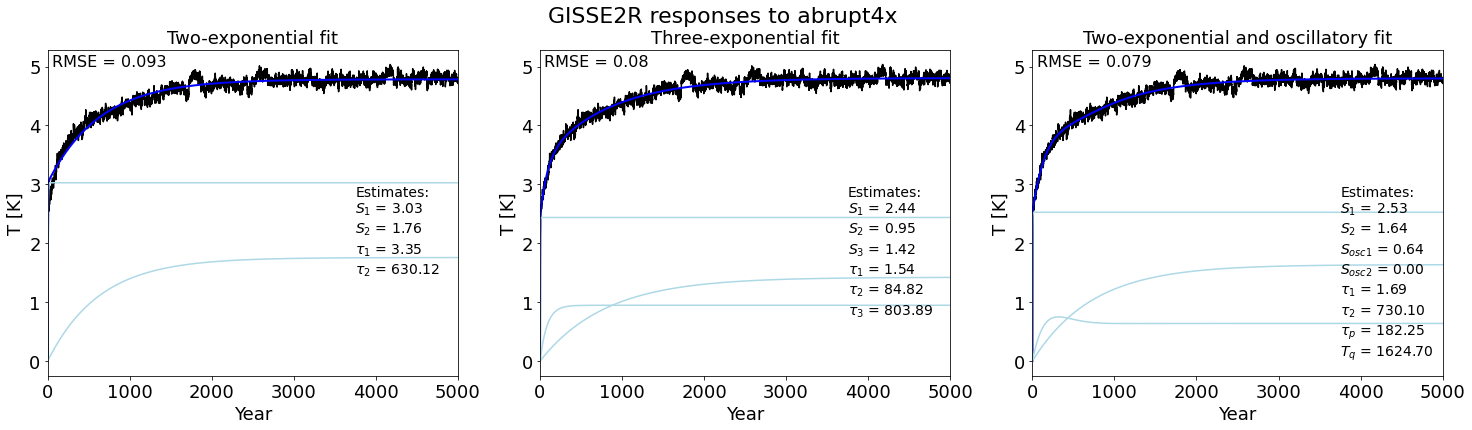

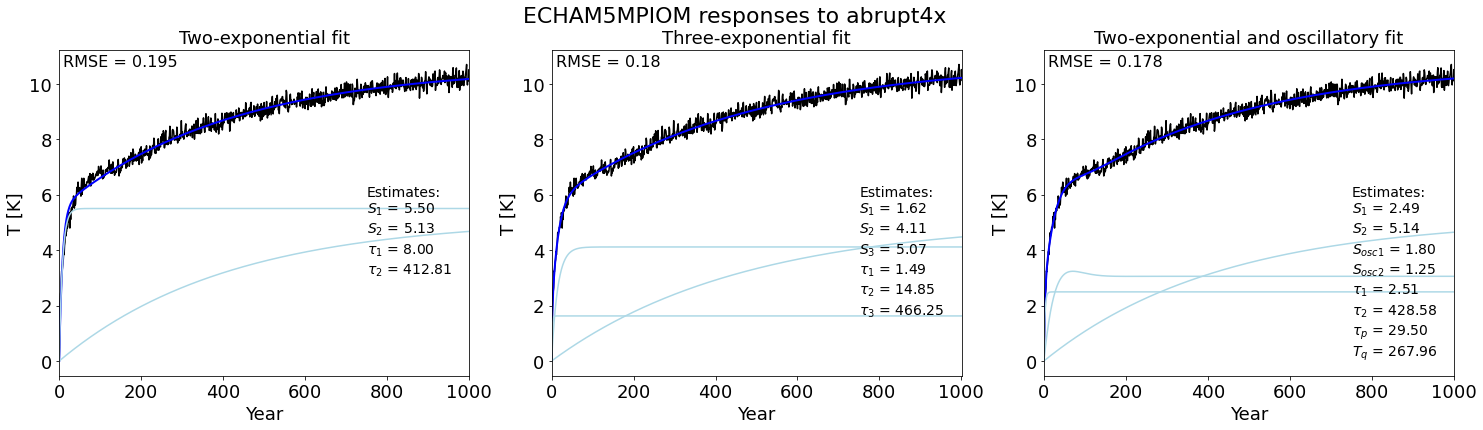

In [64]:
#N_exp = sum(len(all_abruptexp[model]) for model in all_abruptexp.keys()) # the number of rows needed

rmse_list = []
for model in all_abruptexp:
    for exp in all_abruptexp[model]:
        [years0, deltaT0] = get_tas(model, exp, add_0 = True, remove_nan = True, return_years = True)
        #rmse_values = plot_3fits(years0, deltaT0, model, exp)
        rmse_values = plot_3fits(years0, deltaT0, model, exp, load_results = False, save_results = True, save_figure = True)
        rmse_values = [model, exp] + rmse_values
        rmse_list.append(rmse_values)
        plt.show()
        

In [65]:
rmse_df = pd.DataFrame(rmse_list, columns=['model', 'exp', 'RMSE two-exp', 'RMSE three-exp', 'RMSE two-exp + osc'])
rmse_df


,model,exp,RMSE two-exp,RMSE three-exp,RMSE two-exp + osc
0,MPIESM12,abrupt2x,0.123565,0.118542,0.118556
1,MPIESM12,abrupt4x,0.143225,0.131631,0.131665
2,MPIESM12,abrupt8x,0.145984,0.113566,0.113779
3,MPIESM12,abrupt16x,0.170619,0.096500,0.123171
4,HadCM3L,abrupt2x,0.178851,0.175072,0.174366
5,HadCM3L,abrupt4x,0.125355,0.116854,0.117802
6,HadCM3L,abrupt6x,0.123465,0.116568,0.116447
7,HadCM3L,abrupt8x,0.127542,0.123553,0.125332
8,FAMOUS,abrupt2x,0.180351,0.177373,0.177069
9,FAMOUS,abrupt4x,0.214734,0.141899,0.143003


In [67]:
pct_diff1 = pd.DataFrame((rmse_df['RMSE three-exp'] - rmse_df['RMSE two-exp'])/rmse_df['RMSE two-exp']*100, columns = ['% change1']) # percent change
pct_diff2 = pd.DataFrame((rmse_df['RMSE two-exp + osc'] - rmse_df['RMSE three-exp'])/rmse_df['RMSE three-exp']*100, columns = ['% change2']) # percent change

rmse_table = rmse_df.join([np.round(pct_diff1,3), np.round(pct_diff2,3)])
pd.set_option('display.max_rows', None)

# make model the index
rmse_table2 = pd.DataFrame(rmse_table.values[:,1:], columns = rmse_table.columns[1:], index = rmse_table['model'])
rmse_table2;

In [68]:
np.sum(pct_diff2<0)

% change2    11
dtype: int64

In [69]:
s = rmse_table2.style.format(precision=3)
s.set_table_styles([
        {'selector': 'toprule', 'props': ':hline;'},
        {'selector': 'midrule', 'props': ':hline;'},
        {'selector': 'bottomrule', 'props': ':hline;'}]);
print(s.to_latex(column_format= 'lcccccc'))

\begin{tabular}{lcccccc}
\hline
 & exp & RMSE two-exp & RMSE three-exp & RMSE two-exp + osc & % change1 & % change2 \\
model &  &  &  &  &  &  \\
\hline
MPIESM12 & abrupt2x & 0.124 & 0.119 & 0.119 & -4.066 & 0.012 \\
MPIESM12 & abrupt4x & 0.143 & 0.132 & 0.132 & -8.095 & 0.026 \\
MPIESM12 & abrupt8x & 0.146 & 0.114 & 0.114 & -22.206 & 0.188 \\
MPIESM12 & abrupt16x & 0.171 & 0.097 & 0.123 & -43.441 & 27.638 \\
HadCM3L & abrupt2x & 0.179 & 0.175 & 0.174 & -2.113 & -0.403 \\
HadCM3L & abrupt4x & 0.125 & 0.117 & 0.118 & -6.782 & 0.811 \\
HadCM3L & abrupt6x & 0.123 & 0.117 & 0.116 & -5.587 & -0.104 \\
HadCM3L & abrupt8x & 0.128 & 0.124 & 0.125 & -3.127 & 1.440 \\
FAMOUS & abrupt2x & 0.180 & 0.177 & 0.177 & -1.652 & -0.171 \\
FAMOUS & abrupt4x & 0.215 & 0.142 & 0.143 & -33.919 & 0.778 \\
CNRMCM61 & abrupt2x & 0.111 & 0.107 & 0.106 & -3.359 & -1.105 \\
CNRMCM61 & abrupt4x & 0.117 & 0.100 & 0.100 & -14.394 & 0.002 \\
CESM104 & abrupt2x & 0.153 & 0.145 & 0.134 & -4.755 & -7.499 \\
CESM104 & abr

In [48]:
pd.__version__

'1.4.1'

# With linearly increasing forcing to 140 years:

In [108]:
# define a forcing:
def linear_to140years(max_t = 150): # forcing that increases linearly to 1 for the first 140 years, thereafter it remains constant
    forcing_first140 = np.arange(0,141)/140 # including year 0 in array
    forcing_constant = np.tile(1, max_t-140)
    return np.concatenate([forcing_first140, forcing_constant])


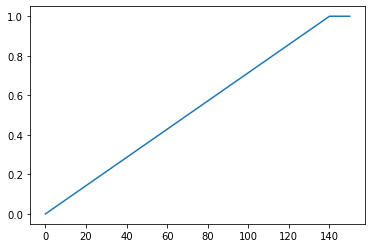

In [111]:
plt.plot(linear_to140years(max_t = 150))

In [112]:
parameters = ['S1', 'S2', 'Sosc1', 'Sosc2', 'tau1', 'tau2', 'taup', 'Tq']
estimates
par_values = {}
for (i,par) in enumerate(parameters):
    par_values[par] = estimates[i]

In [134]:
def osc_part1(t, Sosc1, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    return osc_part1

def osc_part2(t, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part2

In [ ]:
def osc_parts(t, Sosc1, Sosc2, taup, Tq):
    p = -1/taup; q = 2*np.pi/Tq
    osc_part1 = Sosc1*(1 - np.exp(-t/taup)*(np.cos(q*t) + p/q*np.sin(q*t)))
    osc_part2 = Sosc2*(1 - np.exp(-t/taup)*(np.cos(q*t) - q/p*np.sin(q*t)))
    return osc_part1 + osc_part2

In [135]:

def exp_part1_fixedpar(t, par_values):
    return exp_part1(t, S1 = par_values['S1'], tau1 = par_values['tau1'])
def exp_part2_fixedpar(t, par_values):
    return exp_part2(t, S2 = par_values['S2'], tau2 = par_values['tau2'])
def osc_parts_fixedpar(t, par_values):
    return osc_parts(t, Sosc1 = par_values['Sosc1'], Sosc2 = par_values['Sosc2'], taup = par_values['taup'], Tq = par_values['Tq'])
def osc_part1_fixedpar(t, par_values):
    return osc_part1(t, Sosc1 = par_values['Sosc1'], taup = par_values['taup'], Tq = par_values['Tq'])
def osc_part2_fixedpar(t, par_values):
    return osc_part2(t, Sosc2 = par_values['Sosc2'], taup = par_values['taup'], Tq = par_values['Tq'])

def oscillatory_model_fixedpar(t, par_values):
    return exp_part1_fixedpar(t, par_values) + exp_part2_fixedpar(t, par_values) + osc_parts_fixedpar(t, par_values)

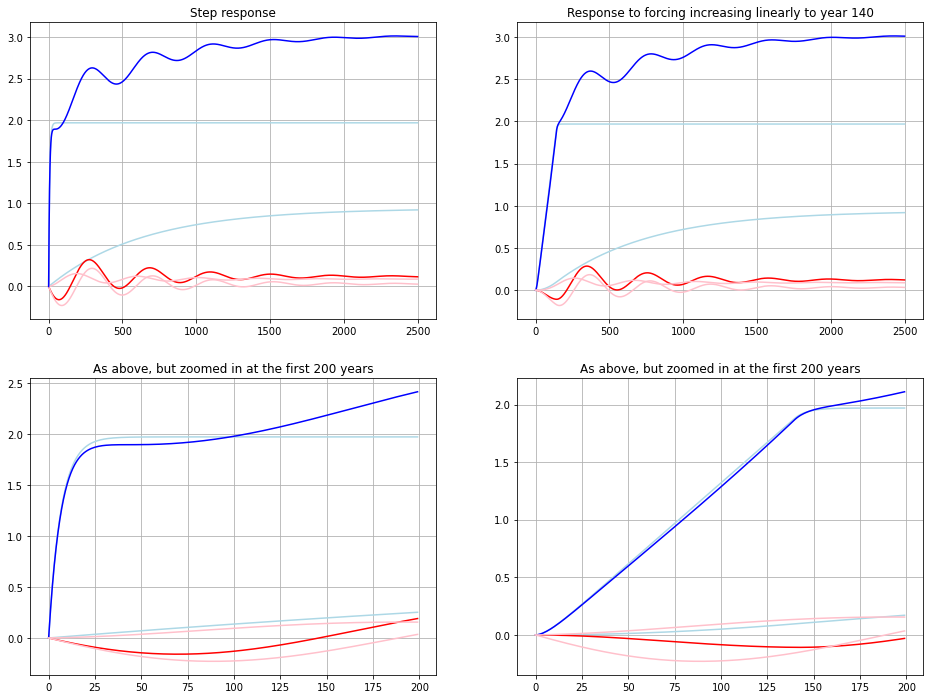

In [146]:
# check that functions work:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [16,6*2]);
max_t = 2500
ax[0,0].plot(exp_part1_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[0,0].plot(exp_part2_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[0,0].plot(osc_parts_fixedpar(np.arange(max_t), par_values), color = 'red')
ax[0,0].plot(osc_part1_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[0,0].plot(osc_part2_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[0,0].plot(oscillatory_model_fixedpar(np.arange(max_t), par_values), color = 'blue')
ax[0,0].set_title('Step response')
ax[0,0].grid()

max_t = 2500
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_parts_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'red')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(oscillatory_model_fixedpar(np.arange(0,max_t), par_values = par_values)), mode = 'full')[:max_t], color = 'blue')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'pink')
ax[0,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'pink')
ax[0,1].set_title('Response to forcing increasing linearly to year 140')
ax[0,1].grid()

max_t = 200
ax[1,0].plot(exp_part1_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[1,0].plot(exp_part2_fixedpar(np.arange(max_t), par_values), color = 'lightblue')
ax[1,0].plot(osc_parts_fixedpar(np.arange(max_t), par_values), color = 'red')
ax[1,0].plot(oscillatory_model_fixedpar(np.arange(max_t), par_values), color = 'blue')
ax[1,0].plot(osc_part1_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,0].plot(osc_part2_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,0].set_title('As above, but zoomed in at the first 200 years')
ax[1,0].grid()

#max_t = 200
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part1_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(exp_part2_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'lightblue')
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(osc_parts_fixedpar(np.arange(max_t), par_values)), mode = 'full')[:max_t], color = 'red')
ax[1,1].plot(np.convolve(linear_to140years(max_t = max_t), np.diff(oscillatory_model_fixedpar(np.arange(0,max_t), par_values = par_values)), mode = 'full')[:max_t], color = 'blue')
ax[1,1].plot(osc_part1_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,1].plot(osc_part2_fixedpar(np.arange(max_t), par_values), color = 'pink')
ax[1,1].set_title('As above, but zoomed in at the first 200 years')
ax[1,1].grid()

#plt.savefig('../Figures/' + model + '_' + exp + '_linresponses_to_linearforcing_v2.pdf', format='pdf', dpi=600, bbox_inches="tight")